In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',')

In [3]:
#all columns
data_all.head()

,INITIAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,41,91.0,50.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,12,401.0,389.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,8,308.0,300.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,12,668.0,656.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,16,271.0,255.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')


In [5]:
#df without dispatch response seconds
data.head()


,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,91.0,50.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,401.0,389.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,308.0,300.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,668.0,656.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,271.0,255.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
data.shape


(100000, 603)

***BINNING INCIDENT_TRAVEL_TM (DISCRETIZING)***



In [7]:
#bins; change n to change num of bins
n = 5 
max = 1025
bin_width = max/n #+1 because we have n bins so n+1 endpoints
bin_width

205.0

In [8]:
#bin ranges
bins = np.linspace(0,max,n+1)
bins

array([   0.,  205.,  410.,  615.,  820., 1025.])

In [9]:
#labels for bin ranges
labels = list(range(1,n+1))
labels

[1, 2, 3, 4, 5]

In [10]:
#df to visualize bins
df = pd.DataFrame(data = labels)
df['start'] = bins[:bins.shape[0]-1]
df['end'] = bins[1:]
df

,0,start,end
0,1,0.0,205.0
1,2,205.0,410.0
2,3,410.0,615.0
3,4,615.0,820.0
4,5,820.0,1025.0


In [11]:
#coding continuous data based on bins/labels, removing continuous data cols
data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin
0,3,91.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7,401.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
2,3,308.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,4,668.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
4,6,271.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [12]:
import collections
from collections import Counter

In [13]:
travel_tm = collections.Counter(data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
travel_tm_count = sum(travel_tm.values())
travel_tm

Counter({1: 11678, 2: 44078, 4: 11164, 3: 28610, 5: 4470})

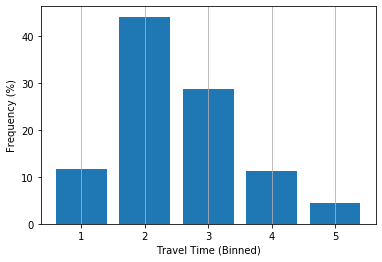

In [14]:
#visualize count of data within each bin
travel_tm = {k: (v*100) / travel_tm_count for k, v in travel_tm.items()} #mult by 100 to turn into percent
plt.bar(travel_tm.keys(),travel_tm.values())
plt.grid(axis = 'x')
plt.xlabel("Travel Time (Binned)")
plt.ylabel("Frequency (%)")
plt.show()

In [15]:
#X is predictors, Y is value to be predicted
X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

X.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3,91.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,401.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,308.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,668.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6,271.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
Y.head()

0    1
1    2
2    2
3    4
4    2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [17]:
#splitting into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

In [18]:
X_train.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
31876,4,75.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
89787,7,840.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
82008,3,423.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
83250,5,225.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
57082,2,404.0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [19]:
Y_train.head()

31876    1
89787    4
82008    2
83250    2
57082    2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [20]:
X_test.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
96692,4,1026.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22916,6,346.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
63161,6,767.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4331,3,664.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9995,2,366.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
Y_test.head()

96692    5
22916    2
63161    4
4331     4
9995     2
Name: INCIDENT_TRAVEL_TM_SECONDS_QY_Bin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

***LOGISTIC REGRESSION***

In [7]:
from sklearn import linear_model
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [23]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
logreg.score(X_train,Y_train)

0.7777866666666666

In [25]:
logreg.score(X_test,Y_test)

0.76764

In [26]:
Y_lr_predict = logreg.predict(X_test)
Y_lr_predict

array([5, 2, 4, ..., 3, 3, 2])

In [27]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_lr_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.99      0.81      0.89      2914
           2       0.77      0.99      0.87     10997
           3       0.66      0.61      0.63      7176
           4       0.77      0.21      0.32      2787
           5       0.97      0.83      0.89      1126

    accuracy                           0.77     25000
   macro avg       0.83      0.69      0.72     25000
weighted avg       0.77      0.77      0.74     25000



In [28]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_lr_predict))

=== Confusion Matrix ===
[[ 2364   550     0     0     0]
 [   16 10940    41     0     0]
 [    0  2788  4384     4     0]
 [    0     0  2187   574    26]
 [    0     0    28   169   929]]


***SVM***

In [52]:
data1 = data.sample(n = 50000)

In [53]:
from sklearn.svm import SVC

In [54]:
#X is predictors, Y is value to be predicted
X = data1.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
Y = data1["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

In [56]:
svm = SVC(kernel = "linear")
svm.fit(X_train,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [57]:
svm.score(X_train,Y_train)

0.9612533333333333

In [58]:
svm.score(X_test,Y_test)

0.94328

In [59]:
Y_svm_predict = svm.predict(X_test)
Y_svm_predict

array([2, 2, 5, ..., 2, 1, 2])

In [60]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_svm_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1487
           2       0.95      0.96      0.95      5440
           3       0.94      0.94      0.94      3647
           4       0.92      0.93      0.92      1359
           5       0.93      0.96      0.95       567

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



In [65]:
#Same as svm.score(Y_test,Y)
metrics.accuracy_score(Y_test,Y_svm_predict)

0.94328

In [61]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_svm_predict))

=== Confusion Matrix ===
[[1355  132    0    0    0]
 [  86 5197  157    0    0]
 [   0  119 3437   91    0]
 [   0    0   63 1258   38]
 [   0    0    0   23  544]]


***Samplesize vs Score***

In [13]:
import random
import numpy as np
import pandas as pd 
from sklearn import linear_model
from sklearn.svm import SVC
#IMPORT YOUR PACKAGES

np.random.seed(2019)

In [4]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',')

In [5]:
## REPLACE THIS WITH MY EXECUTED DICT AND NEW MODEL NAMES+BIN ##
summary_dict = {"LR5":[],"LR12":[],"LR25":[],"LR41":[],
       "SVM5":[],"SVM12":[],"SVM25":[],"SVM41":[],}

In [14]:
num_bins = [5, 12, 25, 41]
samplesize = [1000, 5000, 10000, 25000, 50000]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##
    row_label = 'SVM' + str(n)

    for s in samplesize:
    
        data_sampled = data.sample(n = s)
        
        X = data_sampled.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
        Y = data_sampled["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)
        
        ## REPLACE MODEL below ##
       
        svm = SVC(kernel = "linear")
        svm.fit(X_train,Y_train)
        
        score = svm.score(X_test,Y_test)
                
        ## REPLACE MODEL above ##
        
        summary_dict[row_label].append(score)
        
    

In [17]:
summary_dict

{'LR5': [0.632, 0.6832, 0.7176, 0.75936, 0.7696],
 'LR12': [0.324, 0.3312, 0.358, 0.36656, 0.40664],
 'LR25': [0.128, 0.1512, 0.1668, 0.1744, 0.19808],
 'LR41': [0.072, 0.0912, 0.0964, 0.1096, 0.11728],
 'SVM5': [0.928, 0.9344, 0.9232, 0.93472, 0.94568],
 'SVM12': [0.82, 0.8272, 0.8284, 0.85872, 0.86432],
 'SVM25': [0.656, 0.6576, 0.6612, 0.68656, 0.70392],
 'SVM41': [0.46, 0.4528, 0.4828, 0.52624, 0.55664]}

In [16]:
pd.DataFrame.from_dict(summary_dict,orient = 'index',columns = ['1K','5K','10K','25K','50K'])

,1K,5K,10K,25K,50K
LR5,0.632,0.6832,0.7176,0.75936,0.76960
LR12,0.324,0.3312,0.3580,0.36656,0.40664
LR25,0.128,0.1512,0.1668,0.17440,0.19808
LR41,0.072,0.0912,0.0964,0.10960,0.11728
SVM5,0.928,0.9344,0.9232,0.93472,0.94568
SVM12,0.820,0.8272,0.8284,0.85872,0.86432
SVM25,0.656,0.6576,0.6612,0.68656,0.70392
SVM41,0.460,0.4528,0.4828,0.52624,0.55664
